# ResNet ve PCA Kullanarak Araba Görseli Benzerlik Arama
Bu proje, özellik çıkarımı için önceden eğitilmiş bir ResNet-50 modeli ve boyut indirgeme için PCA kullanarak bir araba görseli benzerlik arama sistemi uygular. Sistem, bir araba görseli sorgusuna en benzer görselleri bir veri kümesinden tanımlamak ve döndürmek için tasarlanmıştır.

## Ana Özellikler
1. **Veri Temizleme ve Artırma**: Bozuk görselleri işleyerek ve genelleştirmeyi iyileştirmek için artırmalar uygulayarak veri kümesinin temiz ve sağlam olmasını sağlar.
2. **Özellik Çıkarımı**: Görsellerden yüksek seviyeli özellikler çıkarmak için ResNet-50 kullanır ve bu özellikler verimli yeniden kullanım için kaydedilir.
3. **Boyut İndirgeme**: Özellik vektörlerinin boyutunu azaltmak için PCA uygular, bu da sistemi daha hızlı ve verimli hale getirir.
4. **Benzerlik Arama**: Sorgu görseli ile veri kümesi görselleri arasındaki kosinüs benzerliğini hesaplar ve en benzer olanları bulur.
5. **Görselleştirme**: Sorgu görselini ve en benzer görselleri benzerlik puanlarıyla birlikte görüntüler.
6. **Model Dağıtımı**: Eğitilmiş ResNet modeli ve PCA dönüşümünü bir Django backend'e entegrasyon için kaydeder.

In [24]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import torch 
from torchvision import models, transforms 
from sklearn.decomposition import PCA 
from sklearn.metrics.pairwise import cosine_similarity 


# Görsellerin Bulunduğu Klasör ve Veri Temizleme & Artırma
Veri kümesindeki görsellerin yolları alınır, bozuk görseller temizlenir ve artırma işlemleri uygulanır. Bu adım, modelin genelleştirme yeteneğini artırır ve yalnızca geçerli görsellerin işlenmesini sağlar.


In [27]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation
from PIL import UnidentifiedImageError

dataset_path = "data"
image_paths = [os.path.join(dataset_path, fname) for fname in os.listdir(dataset_path) if fname.endswith(".jpg")]

print(image_paths)

print(f"Toplam {len(image_paths)} görsel bulundu.")



['data\\00001.jpg', 'data\\00002.jpg', 'data\\00003.jpg', 'data\\00004.jpg', 'data\\00005.jpg', 'data\\00006.jpg', 'data\\00007.jpg', 'data\\00008.jpg', 'data\\00009.jpg', 'data\\00010.jpg', 'data\\00011.jpg', 'data\\00012.jpg', 'data\\00013.jpg', 'data\\00014.jpg', 'data\\00015.jpg', 'data\\00016.jpg', 'data\\00017.jpg', 'data\\00018.jpg', 'data\\00019.jpg', 'data\\00020.jpg', 'data\\00021.jpg', 'data\\00022.jpg', 'data\\00023.jpg', 'data\\00024.jpg', 'data\\00025.jpg', 'data\\00026.jpg', 'data\\00027.jpg', 'data\\00028.jpg', 'data\\00029.jpg', 'data\\00030.jpg', 'data\\00031.jpg', 'data\\00032.jpg', 'data\\00033.jpg', 'data\\00034.jpg', 'data\\00035.jpg', 'data\\00036.jpg', 'data\\00037.jpg', 'data\\00038.jpg', 'data\\00039.jpg', 'data\\00040.jpg', 'data\\00041.jpg', 'data\\00042.jpg', 'data\\00043.jpg', 'data\\00044.jpg', 'data\\00045.jpg', 'data\\00046.jpg', 'data\\00047.jpg', 'data\\00048.jpg', 'data\\00049.jpg', 'data\\00050.jpg', 'data\\00051.jpg', 'data\\00052.jpg', 'data\\0005

Veri Temizleme ve Artırma
Veri kümesi, `data` dizininde saklanan araba görsellerinden oluşur. Aşağıdaki adımlar gerçekleştirilir:
1. **Veri Temizleme**:
   - Geçersiz veya bozuk görseller tanımlanır ve veri kümesinden çıkarılır.
   - Bu, yalnızca geçerli görsellerin işlenmesini sağlar.
2. **Veri Artırma**:
   - Rastgele yatay çevirme ve döndürme işlemleri uygulanarak modelin genelleştirme yeteneği artırılır.
   - Görseller 224x224 piksele yeniden boyutlandırılır, tensörlere dönüştürülür ve ImageNet istatistiklerine göre normalize edilir.


In [ ]:
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_image_paths = []
i=0
for path in image_paths:
    i += 1
    print(f"Processing image {i}/{len(image_paths)}: {path}")
    try:
        img = Image.open(path).convert("RGB")
        valid_image_paths.append(path)
    except (UnidentifiedImageError, FileNotFoundError):
        print(f"Invalid or corrupted image: {path}")

image_paths = valid_image_paths
print(f"Valid images: {len(image_paths)}")


Processing image 1/8144: data\00001.jpg
Processing image 2/8144: data\00002.jpg
Processing image 3/8144: data\00003.jpg
Processing image 4/8144: data\00004.jpg
Processing image 5/8144: data\00005.jpg
Processing image 6/8144: data\00006.jpg
Processing image 7/8144: data\00007.jpg
Processing image 8/8144: data\00008.jpg
Processing image 9/8144: data\00009.jpg
Processing image 10/8144: data\00010.jpg
Processing image 11/8144: data\00011.jpg
Processing image 12/8144: data\00012.jpg
Processing image 13/8144: data\00013.jpg
Processing image 14/8144: data\00014.jpg
Processing image 15/8144: data\00015.jpg
Processing image 16/8144: data\00016.jpg
Processing image 17/8144: data\00017.jpg
Processing image 18/8144: data\00018.jpg
Processing image 19/8144: data\00019.jpg
Processing image 20/8144: data\00020.jpg
Processing image 21/8144: data\00021.jpg
Processing image 22/8144: data\00022.jpg
Processing image 23/8144: data\00023.jpg
Processing image 24/8144: data\00024.jpg
Processing image 25/8144:

# Özellik Çıkarımı (Feature Extraction)
ResNet-50 modeli, görsellerden yüksek seviyeli özellikler çıkarmak için kullanılır. Modelin son katmanı kaldırılır ve tüm katmanlar dondurulur. Her görselden 2048 boyutlu bir özellik vektörü çıkarılır ve kaydedilir.

In [29]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False  

resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = preprocess(image).unsqueeze(0)  
    with torch.no_grad():
        features = resnet(tensor).squeeze()
    return features.numpy().flatten()

feature_list = []
i = 0
for path in image_paths:
    i += 1
    print(f"{i}/{len(image_paths)}: {path}")
    try:
        vec = extract_features(path)
        feature_list.append(vec)
    except Exception as e:
        print(f"Error processing {path}: {e}")

features = np.array(feature_list)
np.save("features.npy", features)
print("Özellik çıkarımı tamamlandı. Shape:", features.shape)

torch.save(resnet.state_dict(), "resnet_model.pth")
print("ResNet modeli kaydedildi.")


c:\Users\shahi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shahi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/8144: data\00001.jpg
2/8144: data\00002.jpg
3/8144: data\00003.jpg
4/8144: data\00004.jpg
5/8144: data\00005.jpg
6/8144: data\00006.jpg
7/8144: data\00007.jpg
8/8144: data\00008.jpg
9/8144: data\00009.jpg
10/8144: data\00010.jpg
11/8144: data\00011.jpg
12/8144: data\00012.jpg
13/8144: data\00013.jpg
14/8144: data\00014.jpg
15/8144: data\00015.jpg
16/8144: data\00016.jpg
17/8144: data\00017.jpg
18/8144: data\00018.jpg
19/8144: data\00019.jpg
20/8144: data\00020.jpg
21/8144: data\00021.jpg
22/8144: data\00022.jpg
23/8144: data\00023.jpg
24/8144: data\00024.jpg
25/8144: data\00025.jpg
26/8144: data\00026.jpg
27/8144: data\00027.jpg
28/8144: data\00028.jpg
29/8144: data\00029.jpg
30/8144: data\00030.jpg
31/8144: data\00031.jpg
32/8144: data\00032.jpg
33/8144: data\00033.jpg
34/8144: data\00034.jpg
35/8144: data\00035.jpg
36/8144: data\00036.jpg
37/8144: data\00037.jpg
38/8144: data\00038.jpg
39/8144: data\00039.jpg
40/8144: data\00040.jpg
41/8144: data\00041.jpg
42/8144: data\00042.jpg
4

PCA ile Boyut İndirgeme
Ana Bileşen Analizi (PCA), çıkarılan özellik vektörlerinin boyutunu 2048'den 128'e düşürür. Bu, hesaplama verimliliğini artırır ve gürültüyü azaltır. Ayrıca, kümülatif açıklanan varyans grafiği çizilerek bileşen seçimi gerekçelendirilir ve PCA modeli kaydedilir.


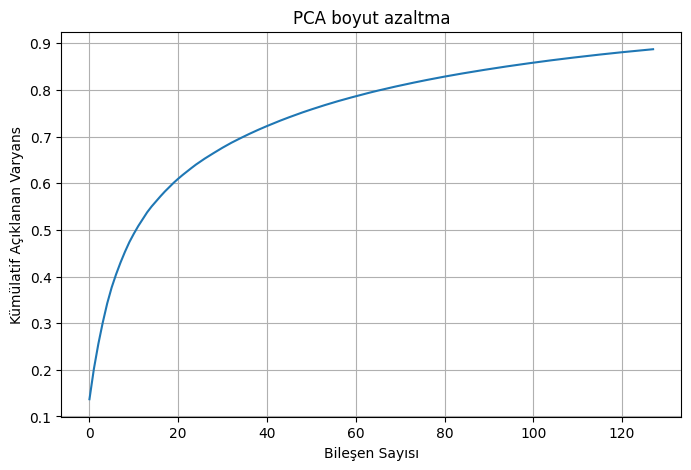

PCA modeli kaydedildi.


In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import joblib


pca = PCA(n_components=128)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Bileşen Sayısı")
plt.ylabel("Kümülatif Açıklanan Varyans")
plt.title("PCA boyut azaltma")
plt.grid()
plt.savefig("pca_variance_plot.png")
plt.show()

joblib.dump(pca, "pca_model.pkl")
print("PCA modeli kaydedildi.")


Benzerlik Arama
Benzerlik arama süreci, bir sorgu görseline en benzer görselleri tanımlar. Adımlar şunlardır:
1. **Özellik Çıkarımı**:
   - Sorgu görseli, ResNet-50 modeli kullanılarak özellik vektörünü çıkarmak için işlenir.
2. **Boyut İndirgeme**:
   - Özellik vektörü, kaydedilen PCA modeli kullanılarak dönüştürülür.
3. **Benzerlik Hesaplama**:
   - Sorgu vektörü ile tüm veri kümesi vektörleri arasındaki kosinüs benzerliği hesaplanır.
   - En yüksek `k` benzerlik puanına sahip görseller tanımlanır.
4. **Görselleştirme**:
   - Sorgu görseli ve en benzer görseller, benzerlik yüzdeleriyle birlikte görüntülenir.
   

In [36]:

def find_similar_images(query_image_path, k=5):
    query_vec = extract_features(query_image_path)
    query_pca = pca.transform([query_vec])
    scores = cosine_similarity(query_pca, features_pca)[0]
    top_indices = np.argsort(scores)[::-1][:k]
    return top_indices, scores[top_indices]

In [43]:
def show_results(query_path, indices, scores):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, len(indices) + 1, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Sorgu")
    plt.axis("off")
    
    for i, (idx, score) in enumerate(zip(indices, scores)):
        plt.subplot(1, len(indices) + 1, i + 2)
        img_path = image_paths[idx]
        plt.imshow(Image.open(img_path))
        plt.title(f"{i+1}. Benzer\n{score*100:.2f}%")
        plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("search_results.png")
    plt.show()

# Sorgulamak istediğiniz araba görseli
